# Модель для предсказания оттока клиентов

## Описание проекта:
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг
Оператор предоставляет два основных типа услуг: 
Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

# План работы

- Загрузка и ознакомление с данными, проверка на пропуски и дубликаты. Подготовить данные к дальнейшиму анализу
- Выделение целевого признака
- Объединение данных
- Исследование данных (разведочный анализ, EDA)
- Проверка корреляций, удалить столбцы с низкой и высокой корреляцией
- Разработать и обучить несколько моделей машинного обучения для решения задачи, г для решения задачи бинарной классификации. Выбрать наилучшую модель по метрике ROC-AUC >= 0.85. При разработке модели учитывать проблему переобучения; провести масштабирование и нормализацию признаков, где необходимо.
- посчитать дополнительную метрику accuracy
- проанализировать матрицу ошибок и важность признаков

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

# 1.Загрузка и преобработка данных


In [2]:
try:
    contract = pd.read_csv('D:\DDownloads/contract_new.csv') 
except FileNotFoundError:
    contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')

In [3]:
contract.sample(5)

customerID   BeginDate EndDate            Type PaperlessBilling  \
2764  1810-MVMAI  2017-08-01      No  Month-to-month               No   
1504  1769-GRUIK  2018-08-01      No  Month-to-month              Yes   
1661  3761-FLYZI  2014-09-01      No  Month-to-month              Yes   
3575  9501-UKKNL  2015-03-01      No  Month-to-month              Yes   
3148  2452-SNHFZ  2016-03-01      No  Month-to-month               No   

                  PaymentMethod  MonthlyCharges TotalCharges  
2764           Electronic check           67.60       2028.0  
1504           Electronic check           71.10       1279.8  
1661  Bank transfer (automatic)          108.80      7284.16  
3575           Electronic check           51.70      3141.81  
3148    Credit card (automatic)           75.45      3794.38

In [4]:
display(contract.info())
display(contract.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

In [5]:
print('дубликаты:')
contract[contract.duplicated()]

дубликаты:


Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges]
Index: []

смотрим на значения в каждой колонке

In [6]:
for col in contract.columns: 
    print('{} : {}'.format(col, contract[col].unique()))

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate : ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015

In [7]:
contract.EndDate.value_counts(dropna=False)

No            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2014-09-01       2
2014-12-01       2
2014-06-01       1
2014-10-01       1
2014-11-01       1
Name: EndDate, Length: 67, dtype: int64

In [8]:
print(contract.EndDate.min())
print(contract.EndDate.max())

2014-06-01
No


колонка EndDate так же содержит строковое значение No, Замение ее на дату актуальности датасета, а именно на 2020/02/01

In [9]:
contract['Churn'] = np.where(contract['EndDate'] == 'No', 0, 1)
contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])
contract.sample(20)

customerID   BeginDate     EndDate            Type PaperlessBilling  \
1073  0655-RBDUG  2019-03-01  2020-02-01  Month-to-month              Yes   
6373  0943-ZQPXH  2016-06-01  2019-11-01  Month-to-month              Yes   
4531  4910-AQFFX  2019-02-01  2019-10-01  Month-to-month              Yes   
878   7945-HLKEA  2015-02-01  2020-02-01        One year               No   
3229  5519-NPHVG  2018-11-01  2020-02-01  Month-to-month              Yes   
3094  1898-JSNDC  2016-11-01  2020-02-01        One year              Yes   
4492  3120-FAZKD  2015-08-01  2019-08-01        Two year              Yes   
2281  9578-VRMNM  2018-08-01  2019-10-01  Month-to-month              Yes   
670   5642-MHDQT  2015-09-01  2020-02-01        One year              Yes   
1173  0107-WESLM  2019-09-01  2020-02-01  Month-to-month              Yes   
6213  8999-EXMNO  2018-07-01  2020-02-01        Two year               No   
6440  2809-ZMYOQ  2017-06-01  2020-01-01  Month-to-month              Yes   
1099  6921-OZMFH  2019-09-01  2020-02-01  Month-to-month              Yes   
6063  0613-WUXUM  2014-04-01  2020-02-01        Two year              Yes   
3407  1167-OYZJF  2014-07-01  2020-02-01        Two year              Yes   
3638  7579-OOPEC  2019-08-01  2020-02-01  Month-to-month               No   
3026  6127-ISGTU  2018-09-01  2020-02-01  Month-to-month              Yes   
2117  4139-DETXS  2014-02-01  2020-02-01        Two year               No   
771   0236-HFWSV  2018-08-01  2020-02-01  Month-to-month              Yes   
1460  2952-QAYZF  2019-06-01  2020-02-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  Churn  
1073  Bank transfer (automatic)           98.05      1078.55      0  
6373  Bank transfer (automatic)           92.95      4153.94      1  
4531  Bank transfer (automatic)           79.35        634.8      1  
878            Electronic check           64.75      4001.55      0  
3229           Electronic check           94.20       1413.0      0  
3094    Credit card (automatic)           58.60       2285.4      0  
4492  Bank transfer (automatic)           24.05      1212.12      1  
2281    Credit card (automatic)           65.20      1004.08      1  
670   Bank transfer (automatic)           19.85      1136.21      0  
1173           Electronic check           19.85       100.24      0  
6213               Mailed check           20.15       409.65      0  
6440           Electronic check          101.35      3141.85      1  
1099               Mailed check           55.70        278.5      0  
6063               Mailed check           19.20       1344.0      0  
3407  Bank transfer (automatic)           20.05      1343.35      0  
3638    Credit card (automatic)           50.15        300.9      0  
3026           Electronic check           84.95      1444.15      0  
2117  Bank transfer (automatic)           64.45      4733.21      0  
771            Electronic check           93.35       1680.3      0  
1460           Electronic check           85.30       730.17      0

In [10]:
contract[contract['TotalCharges'] ==' ']

customerID   BeginDate     EndDate      Type PaperlessBilling  \
488   4472-LVYGI  2020-02-01  2020-02-01  Two year              Yes   
753   3115-CZMZD  2020-02-01  2020-02-01  Two year               No   
936   5709-LVOEQ  2020-02-01  2020-02-01  Two year               No   
1082  4367-NUYAO  2020-02-01  2020-02-01  Two year               No   
1340  1371-DWPAZ  2020-02-01  2020-02-01  Two year               No   
3331  7644-OMVMY  2020-02-01  2020-02-01  Two year               No   
3826  3213-VVOLG  2020-02-01  2020-02-01  Two year               No   
4380  2520-SGTTA  2020-02-01  2020-02-01  Two year               No   
5218  2923-ARZLG  2020-02-01  2020-02-01  One year              Yes   
6670  4075-WKNIU  2020-02-01  2020-02-01  Two year               No   
6754  2775-SEFEE  2020-02-01  2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  Churn  
488   Bank transfer (automatic)           52.55                   0  
753                Mailed check           20.25                   0  
936                Mailed check           80.85                   0  
1082               Mailed check           25.75                   0  
1340    Credit card (automatic)           56.05                   0  
3331               Mailed check           19.85                   0  
3826               Mailed check           25.35                   0  
4380               Mailed check           20.00                   0  
5218               Mailed check           19.70                   0  
6670               Mailed check           73.35                   0  
6754  Bank transfer (automatic)           61.90                   0

в колонке TotalCharges не явные пропуски, это относится к клиентам которые заключили договара в текущем месяце 2020-02-01, и у них еще нет общей суммы. заменим на месячный показатель

In [11]:
contract['TotalCharges'] = contract.apply(lambda row: row['MonthlyCharges'] if
                                          row['TotalCharges'].strip() == '' else
                                          row['TotalCharges'], axis=1)

In [12]:
#sanity check по customer #488
contract.iloc[488:489]

customerID   BeginDate     EndDate      Type PaperlessBilling  \
488  4472-LVYGI  2020-02-01  2020-02-01  Two year              Yes   

                 PaymentMethod  MonthlyCharges TotalCharges  Churn  
488  Bank transfer (automatic)           52.55        52.55      0

In [13]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype('int')
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   int32  
 7   TotalCharges      7043 non-null   float64
 8   Churn             7043 non-null   int32  
dtypes: float64(1), int32(2), object(6)
memory usage: 440.3+ KB


In [15]:
#изменим тип данных
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'])


contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   int32         
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(4)
memory usage: 440.3+ KB


In [16]:
print(contract.EndDate.min())
print(contract.EndDate.max())

2014-06-01 00:00:00
2020-02-01 00:00:00


In [17]:
contract.Churn.value_counts(dropna=False)

0    5942
1    1101
Name: Churn, dtype: int64

### Промежуточный вывод

создан целевой признак, колонка Churn на основе наличия конечной даты в колонке EndDate. Дубликатов не обнаружено, а  пропущенные  значения в колонке TotalCharges заменены на 0. Так же изменены типы колонок на datetime

#### personal_new

In [18]:
try:
    personal = pd.read_csv('D:\DDownloads/personal_new.csv') 
except FileNotFoundError:
    personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')

In [19]:
personal

customerID  gender  SeniorCitizen Partner Dependents
0     7590-VHVEG  Female              0     Yes         No
1     5575-GNVDE    Male              0      No         No
2     3668-QPYBK    Male              0      No         No
3     7795-CFOCW    Male              0      No         No
4     9237-HQITU  Female              0      No         No
...          ...     ...            ...     ...        ...
7038  6840-RESVB    Male              0     Yes        Yes
7039  2234-XADUH  Female              0     Yes        Yes
7040  4801-JZAZL  Female              0     Yes        Yes
7041  8361-LTMKD    Male              1     Yes         No
7042  3186-AJIEK    Male              0      No         No

[7043 rows x 5 columns]

In [20]:
print(personal.shape)
print(personal.info())
print(personal.describe())

(7043, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [21]:
print('Duplicated rows:')
personal[personal.duplicated()]

Duplicated rows:


Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents]
Index: []

In [22]:
for col in personal.columns: 
    print('{} : {}'.format(col, personal[col].unique()))

customerID : ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']


In [23]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})
personal.head()

customerID  gender SeniorCitizen Partner Dependents
0  7590-VHVEG  Female            No     Yes         No
1  5575-GNVDE    Male            No      No         No
2  3668-QPYBK    Male            No      No         No
3  7795-CFOCW    Male            No      No         No
4  9237-HQITU  Female            No      No         No

#### Промежуточный вывод

аномалий в данных не обнаружено, содержат котегориальные данные, идем дальше

#### internet_new

In [24]:
try:
    internet = pd.read_csv('D:\DDownloads/internet_new.csv') 
except FileNotFoundError:
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')

In [25]:
internet

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingTV StreamingMovies  
0             No          No              No  
1             No          No              No  
2             No          No              No  
3            Yes          No              No  
4             No          No              No  
...          ...         ...             ...  
5512         Yes         Yes             Yes  
5513          No         Yes             Yes  
5514          No          No              No  
5515          No          No              No  
5516         Yes         Yes             Yes  

[5517 rows x 8 columns]

In [26]:
print(internet.shape)
print(internet.info())
display(internet.describe())

(5517, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

In [27]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [28]:
internet[internet.duplicated()]

Empty DataFrame
Columns: [customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies]
Index: []

In [29]:
for col in internet:
    print('{} : {}'.format(internet, internet[col].unique()))

      customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0     7590-VHVEG             DSL             No          Yes               No   
1     5575-GNVDE             DSL            Yes           No              Yes   
2     3668-QPYBK             DSL            Yes          Yes               No   
3     7795-CFOCW             DSL            Yes           No              Yes   
4     9237-HQITU     Fiber optic             No           No               No   
...          ...             ...            ...          ...              ...   
5512  6840-RESVB             DSL            Yes           No              Yes   
5513  2234-XADUH     Fiber optic             No          Yes              Yes   
5514  4801-JZAZL             DSL            Yes           No               No   
5515  8361-LTMKD     Fiber optic             No           No               No   
5516  3186-AJIEK     Fiber optic            Yes           No              Yes   

     TechSupport StreamingT

#### промежуточный вывод

аномалий в данных не обнаружено, содержать категиоральные значения. Идем дальше

#### phone_new

In [30]:
try:
    phone = pd.read_csv('D:\DDownloads/phone_new.csv') 
except FileNotFoundError:
    phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [31]:
phone

customerID MultipleLines
0     5575-GNVDE            No
1     3668-QPYBK            No
2     9237-HQITU            No
3     9305-CDSKC           Yes
4     1452-KIOVK           Yes
...          ...           ...
6356  2569-WGERO            No
6357  6840-RESVB           Yes
6358  2234-XADUH           Yes
6359  8361-LTMKD           Yes
6360  3186-AJIEK            No

[6361 rows x 2 columns]

In [32]:
print(phone.shape)
phone.info()
phone.describe()

(6361, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

#### Промежуточный вывод
аномалий в данных не обнаружено, содержать категиоральные значения. Идем дальше

# 2.Исследование данных

In [33]:
df = (
    pd.merge(contract, internet, how='left', on='customerID')
    .merge(personal, how='left', on='customerID')
    .merge(phone, how='left', on='customerID')
)

In [34]:
df.sample(5)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
30    3841-NFECX 2014-03-01 2018-11-01        Two year              Yes   
6961  8155-IBNHG 2017-12-01 2020-02-01  Month-to-month              Yes   
5180  0361-HJRDX 2014-06-01 2020-02-01        Two year               No   
3707  9537-JALFH 2014-05-01 2020-02-01        Two year               No   
725   6549-YMFAW 2019-05-01 2020-02-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
30      Credit card (automatic)              96       5395.60      1   
6961    Credit card (automatic)              75       1960.40      0   
5180    Credit card (automatic)              64       4769.62      0   
3707  Bank transfer (automatic)              19       1373.10      0   
725                Mailed check              21        191.25      0   

     InternetService  ... OnlineBackup DeviceProtection TechSupport  \
30       Fiber optic  ...          Yes              Yes         Yes   
6961     Fiber optic  ...           No               No          No   
5180             DSL  ...          Yes              Yes         Yes   
3707             NaN  ...          NaN              NaN         NaN   
725              NaN  ...          NaN              NaN         NaN   

     StreamingTV StreamingMovies  gender SeniorCitizen Partner Dependents  \
30            No              No  Female           Yes     Yes         No   
6961          No              No  Female            No     Yes         No   
5180         Yes             Yes  Female            No      No         No   
3707         NaN             NaN    Male            No     Yes        Yes   
725          NaN             NaN    Male           Yes     Yes         No   

     MultipleLines  
30             Yes  
6961           Yes  
5180           NaN  
3707            No  
725             No  

[5 rows x 21 columns]

In [35]:
df.shape

(7043, 21)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   int32         
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int32         
 9   InternetService   5517 non-null   object        
 10  OnlineSecurity    5517 non-null   object        
 11  OnlineBackup      5517 non-null   object        
 12  DeviceProtection  5517 non-null   object        
 13  TechSupport       5517 non-null   object        
 14  StreamingTV       5517 n

In [39]:
df.isna().mean()

customerID          0.000000
BeginDate           0.000000
EndDate             0.000000
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.000000
Churn               0.000000
InternetService     0.216669
OnlineSecurity      0.216669
OnlineBackup        0.216669
DeviceProtection    0.216669
TechSupport         0.216669
StreamingTV         0.216669
StreamingMovies     0.216669
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
MultipleLines       0.096834
dtype: float64

In [38]:
df.sample(20)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
2732  9929-PLVPA 2019-10-01 2020-02-01  Month-to-month               No   
3846  1767-TGTKO 2019-06-01 2020-02-01  Month-to-month              Yes   
3192  1231-YNDEK 2015-04-01 2020-02-01        Two year              Yes   
3762  0430-IHCDJ 2018-11-01 2020-02-01  Month-to-month              Yes   
53    7495-OOKFY 2019-03-01 2020-02-01  Month-to-month              Yes   
2273  0219-QAERP 2017-08-01 2020-02-01        One year               No   
4868  2568-OIADY 2016-12-01 2018-11-01  Month-to-month              Yes   
5574  5546-BYZSM 2016-09-01 2020-02-01  Month-to-month               No   
2863  4146-SVFUD 2020-01-01 2020-02-01  Month-to-month               No   
1451  6890-PFRQX 2018-08-01 2020-02-01  Month-to-month               No   
7039  2234-XADUH 2014-02-01 2020-02-01        One year              Yes   
4854  1337-BOZWO 2018-08-01 2020-02-01        One year               No   
327   5804-LEPIM 2019-10-01 2020-02-01  Month-to-month              Yes   
4220  4644-OBGFZ 2015-07-01 2020-02-01        One year               No   
6976  5130-YPIRV 2014-12-01 2017-02-01        Two year              Yes   
5882  2138-VFAPZ 2018-12-01 2020-02-01        Two year              Yes   
512   5956-VKDTT 2019-06-01 2020-02-01  Month-to-month              Yes   
2902  1658-TJVOA 2019-08-01 2020-02-01  Month-to-month              Yes   
4548  5572-ZDXHY 2018-02-01 2020-02-01  Month-to-month              Yes   
325   4983-CLMLV 2015-10-01 2018-05-01  Month-to-month              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
2732    Credit card (automatic)              20         88.94      0   
3846           Electronic check              45        374.51      0   
3192  Bank transfer (automatic)              19       1110.70      0   
3762           Electronic check              49        779.10      0   
53      Credit card (automatic)              80        887.15      0   
2273    Credit card (automatic)              19        594.00      0   
4868           Electronic check              99       2288.50      1   
5574           Electronic check              20        838.45      0   
2863               Mailed check              44         44.60      0   
1451               Mailed check              69       1363.59      0   
7039    Credit card (automatic)             103       7430.40      0   
4854    Credit card (automatic)              46        835.20      0   
327            Electronic check              70        284.21      0   
4220               Mailed check              19       1115.40      0   
6976    Credit card (automatic)              72       1872.00      1   
5882               Mailed check              19        275.80      0   
512            Electronic check              74        600.75      0   
2902           Electronic check              74        444.60      0   
4548               Mailed check              84       2083.90      0   
325     Credit card (automatic)             102       3183.70      1   

     InternetService  ... OnlineBackup DeviceProtection TechSupport  \
2732             NaN  ...          NaN              NaN         NaN   
3846             DSL  ...           No               No          No   
3192             NaN  ...          NaN              NaN         NaN   
3762             DSL  ...           No               No          No   
53       Fiber optic  ...          Yes               No          No   
2273             NaN  ...          NaN              NaN         NaN   
4868     Fiber optic  ...           No              Yes          No   
5574             NaN  ...          NaN              NaN         NaN   
2863             DSL  ...           No               No          No   
1451             DSL  ...           No              Yes          No   
7039     Fiber optic  ...          Yes              Yes          No   
4854             DSL  ...          Yes              Yes          

In [45]:
display(df[df['customerID'] == '0219-QAERP'])

customerID  BeginDate    EndDate      Type PaperlessBilling  \
2273  0219-QAERP 2017-08-01 2020-02-01  One year               No   

                PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
2273  Credit card (automatic)              19         594.0      0   

     InternetService  ... OnlineBackup DeviceProtection TechSupport  \
2273             NaN  ...          NaN              NaN         NaN   

     StreamingTV StreamingMovies gender SeniorCitizen Partner Dependents  \
2273         NaN             NaN   Male            No     Yes         No   

     MultipleLines  
2273            No  

[1 rows x 21 columns]

In [46]:
df.iloc[2273]

customerID                       0219-QAERP
BeginDate               2017-08-01 00:00:00
EndDate                 2020-02-01 00:00:00
Type                               One year
PaperlessBilling                         No
PaymentMethod       Credit card (automatic)
MonthlyCharges                           19
TotalCharges                          594.0
Churn                                     0
InternetService                         NaN
OnlineSecurity                          NaN
OnlineBackup                            NaN
DeviceProtection                        NaN
TechSupport                             NaN
StreamingTV                             NaN
StreamingMovies                         NaN
gender                                 Male
SeniorCitizen                            No
Partner                                 Yes
Dependents                               No
MultipleLines                            No
Name: 2273, dtype: object

In [59]:
df.customerID.duplicated().sum()

0

In [52]:
filtered_df = df[df['InternetService'].isna() & df['OnlineSecurity'].isna() & df['OnlineBackup'].isna() & df['DeviceProtection'].isna() & df['TechSupport'].isna() & df['StreamingTV'].isna() & df['StreamingMovies'].isna()]
filtered_df

customerID  BeginDate    EndDate            Type PaperlessBilling  \
11    7469-LKBCI 2018-10-01 2020-02-01        Two year               No   
16    8191-XWSZG 2015-10-01 2020-02-01        One year               No   
21    1680-VDCWW 2019-02-01 2020-02-01        One year               No   
22    1066-JKSGK 2019-11-01 2020-02-01  Month-to-month               No   
33    7310-EGVHZ 2020-01-01 2020-02-01  Month-to-month               No   
...          ...        ...        ...             ...              ...   
7017  4807-IZYOZ 2015-11-01 2020-02-01        Two year               No   
7019  9710-NJERN 2016-11-01 2020-02-01        Two year               No   
7020  9837-FWLCH 2019-02-01 2020-02-01  Month-to-month              Yes   
7030  0871-OPBXW 2019-12-01 2020-02-01  Month-to-month              Yes   
7037  2569-WGERO 2014-02-01 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
11      Credit card (automatic)              18        312.30      0   
16                 Mailed check              20       1106.01      0   
21    Bank transfer (automatic)              19        237.60      0   
22                 Mailed check              20         61.05      0   
33    Bank transfer (automatic)              20         22.22      0   
...                         ...             ...           ...    ...   
7017  Bank transfer (automatic)              20       1053.15      0   
7019               Mailed check              20        785.85      0   
7020           Electronic check              19        246.53      0   
7030               Mailed check              20         40.10      0   
7037  Bank transfer (automatic)              21       1553.26      0   

     InternetService  ... OnlineBackup DeviceProtection TechSupport  \
11               NaN  ...          NaN              NaN         NaN   
16               NaN  ...          NaN              NaN         NaN   
21               NaN  ...          NaN              NaN         NaN   
22               NaN  ...          NaN              NaN         NaN   
33               NaN  ...          NaN              NaN         NaN   
...              ...  ...          ...              ...         ...   
7017             NaN  ...          NaN              NaN         NaN   
7019             NaN  ...          NaN              NaN         NaN   
7020             NaN  ...          NaN              NaN         NaN   
7030             NaN  ...          NaN              NaN         NaN   
7037             NaN  ...          NaN              NaN         NaN   

     StreamingTV StreamingMovies  gender SeniorCitizen Partner Dependents  \
11           NaN             NaN    Male            No      No         No   
16           NaN             NaN  Female            No      No         No   
21           NaN             NaN    Male            No     Yes         No   
22           NaN             NaN    Male            No      No         No   
33           NaN             NaN    Male            No      No         No   
...          ...             ...     ...           ...     ...        ...   
7017         NaN             NaN  Female            No      No         No   
7019         NaN             NaN  Female            No      No         No   
7020         NaN             NaN    Male            No     Yes        Yes   
7030         NaN             NaN  Female            No      No         No   
7037         NaN             NaN  Female            No      No         No   

     MultipleLines  
11              No  
16              No  
21              No  
22              No  
33              No  
...            ...  
7017            No  
7019            No  
7020            No  
7030            No  
7037            No  

[1526 rows x 21 columns]

In [56]:
filtered_df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines'],
      dtype='object')

In [55]:
filtered_df.MultipleLines.value_counts(dropna=False)

No     1184
Yes     342
Name: MultipleLines, dtype: int64

In [57]:
filtered_df.Churn.value_counts(dropna=False)

0    1366
1     160
Name: Churn, dtype: int64

In [51]:
filtered_df_ml = df[df['InternetService'].isna() & df['OnlineSecurity'].isna() & df['OnlineBackup'].isna() & df['DeviceProtection'].isna() & df['TechSupport'].isna() & df['StreamingTV'].isna() & df['StreamingMovies'].isna() & df['MultipleLines'].isna()]
filtered_df_ml

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, gender, SeniorCitizen, Partner, Dependents, MultipleLines]
Index: []

[0 rows x 21 columns]

В некоторых столбцах с категориальными значеями наблюдается пропуски. в колонке MultipleLines менее 10% пропусков, их можно удалить но по требованию удалять данные нельзя. Пропуски появились из за того что не каждый клиент пользуется телефонией и интернетом. заполним пропуски загшлушкой

In [39]:
df['InternetService'] = df['InternetService'].fillna('Undefined')
df['OnlineSecurity'] =df['OnlineSecurity'].fillna('Undefined')
df['OnlineBackup'] = df['OnlineBackup'].fillna('Undefined')
df['DeviceProtection'] = df['DeviceProtection'].fillna('Undefined')
df['TechSupport'] = df['TechSupport'].fillna('Undefined')
df['StreamingTV'] = df['StreamingTV'].fillna('Undefined')
df['StreamingMovies'] = df['StreamingMovies'].fillna('Undefined')
df['MultipleLines'] = df['MultipleLines'].fillna('Undefined')

In [40]:
df.isna().mean()

customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
MultipleLines       0.0
dtype: float64

In [41]:
df.duplicated().sum()

0

In [42]:
df[df.customerID.duplicated()]

Empty DataFrame
Columns: [customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, gender, SeniorCitizen, Partner, Dependents, MultipleLines]
Index: []

[0 rows x 21 columns]

In [43]:
df['Churn'].value_counts()

0    5942
1    1101
Name: Churn, dtype: int64

Так же добавим признак длительность клиента, так как дальше для модели нельзя использывать абсолютные даты

In [44]:
df['duration'] = (df['EndDate'] - df['BeginDate']).dt.days

In [45]:
df

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2     3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4     9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7038  6840-RESVB 2018-02-01 2020-02-01        One year              Yes   
7039  2234-XADUH 2014-02-01 2020-02-01        One year              Yes   
7040  4801-JZAZL 2019-03-01 2020-02-01  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2020-02-01  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01 2020-02-01        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  Churn  \
0              Electronic check              29         31.04      0   
1                  Mailed check              56       2071.84      0   
2                  Mailed check              53        226.17      0   
3     Bank transfer (automatic)              42       1960.60      0   
4              Electronic check              70        353.50      0   
...                         ...             ...           ...    ...   
7038               Mailed check              84       2035.20      0   
7039    Credit card (automatic)             103       7430.40      0   
7040           Electronic check              29        325.60      0   
7041               Mailed check              74        520.80      0   
7042  Bank transfer (automatic)             105       7251.82      0   

     InternetService  ... DeviceProtection TechSupport StreamingTV  \
0                DSL  ...               No          No          No   
1                DSL  ...              Yes          No          No   
2                DSL  ...               No          No          No   
3                DSL  ...              Yes         Yes          No   
4        Fiber optic  ...               No          No          No   
...              ...  ...              ...         ...         ...   
7038             DSL  ...              Yes         Yes         Yes   
7039     Fiber optic  ...              Yes          No         Yes   
7040             DSL  ...               No          No          No   
7041     Fiber optic  ...               No          No          No   
7042     Fiber optic  ...              Yes         Yes         Yes   

     StreamingMovies  gender SeniorCitizen Partner Dependents MultipleLines  \
0                 No  Female            No     Yes         No     Undefined   
1                 No    Male            No      No         No            No   
2                 No    Male            No      No         No            No   
3                 No    Male            No      No         No     Undefined   
4                 No  Female            No      No         No            No   
...              ...     ...           ...     ...        ...           ...   
7038             Yes    Male            No     Yes        Yes           Yes   
7039             Yes  Female            No     Yes        Yes           Yes   
7040              No  Female            No     Yes        Yes     Undefined   
7041              No    Male           Yes     Yes         No           Yes   
7042             Yes    Male            No      No         No            No   

     duration  
0          31  
1        1036  
2         123  
3        1371  
4         153  
...       ...  
7038      730  
7039     2191  
7040      337  
7041      215  
7042     2010  

[7043 rows x 22 columns]

In [46]:
!pip install -q phik

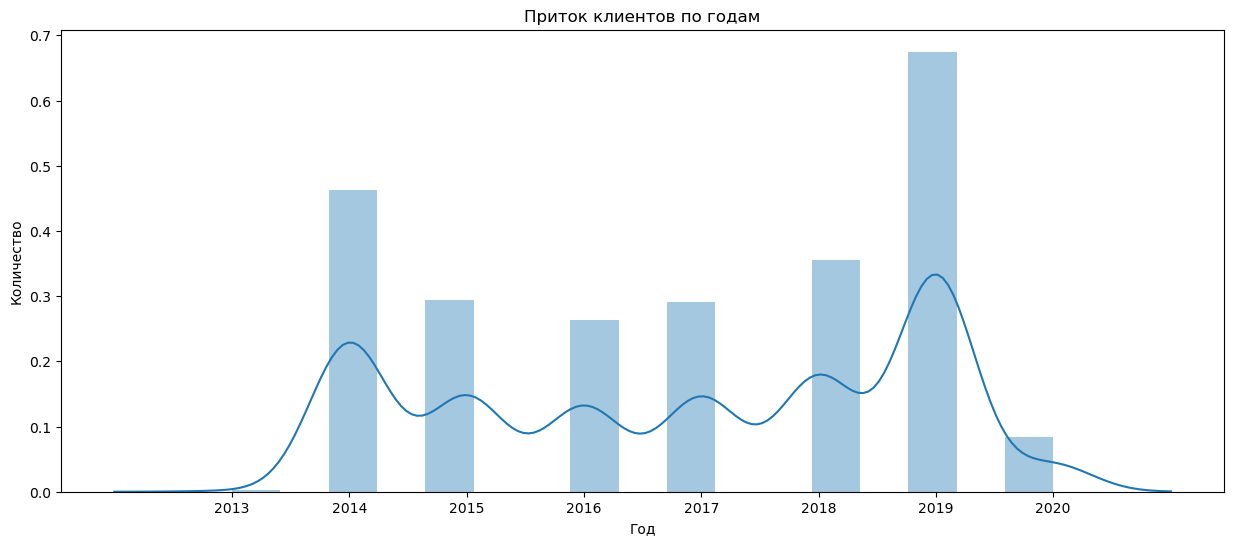

In [47]:
f, ax_hist = plt.subplots(figsize=(15, 6))
 
sns.distplot(df['BeginDate'].dt.year, ax=ax_hist)
 
plt.title('Приток клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')

plt.xticks(range(df['BeginDate'].dt.year.min(), df['BeginDate'].dt.year.max() + 1, 1))

plt.show()

Данные о привлечении клиентов представлены за период с 2014 года по начало 2020 года. В 2016 году было привлечено минимальное количество клиентов, а в 2019 году - наибольшее. С 2016 года наблюдается стабильный рост привлечения клиентов

<function matplotlib.pyplot.show(close=None, block=None)>

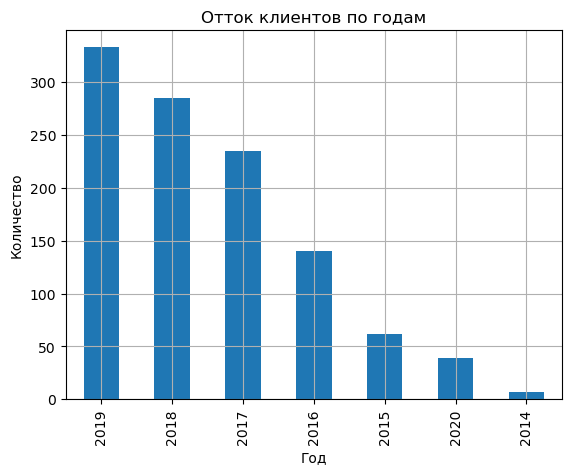

In [48]:
df.query('Churn == 1')['EndDate'].dt.year.value_counts().plot(kind ='bar', grid=True)
plt.title('Отток клиентов по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

как видим по графику все прошлые года с каждым послдедующим  годом с все больше и больше клиентов уходило 

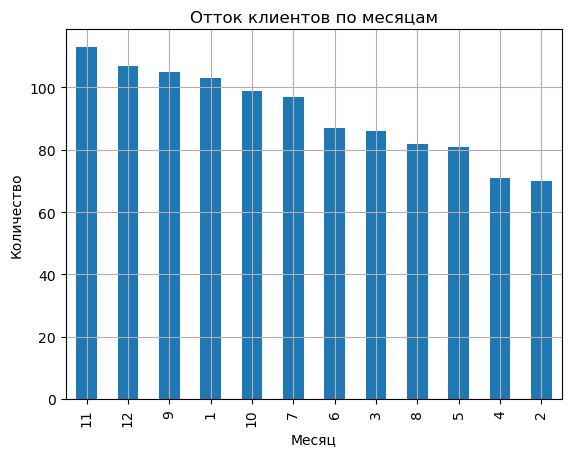

In [49]:
df.query('Churn == 1')['EndDate'].dt.month.value_counts().plot(kind ='bar', grid=True)
plt.title('Отток клиентов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show;

самые большие месяца оттока в конце либо в начале года, что логично если заключать годовые контракты

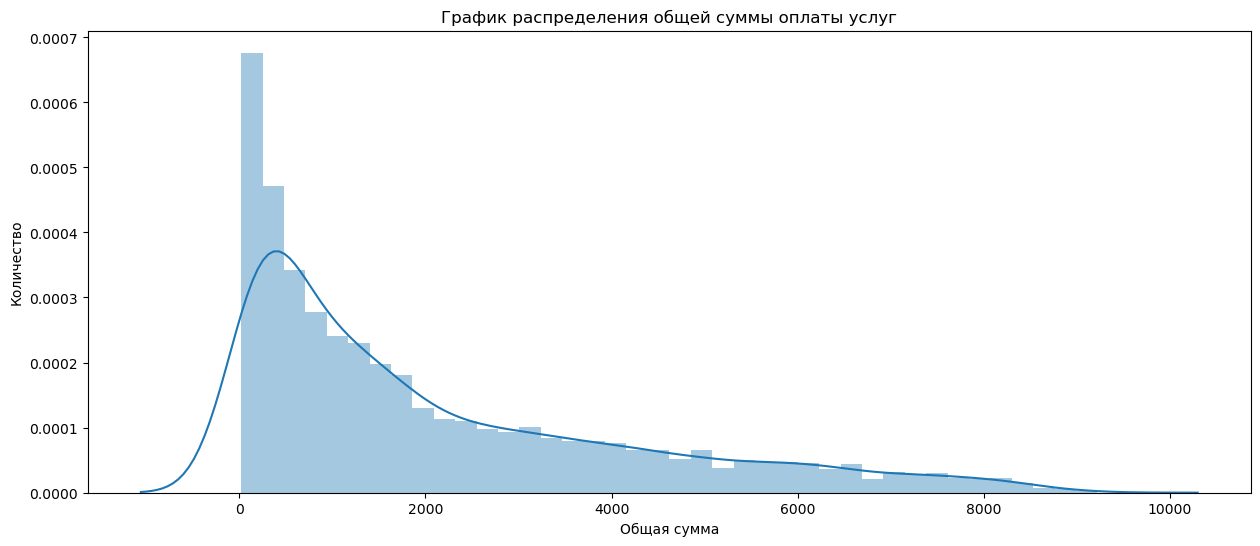

In [50]:
f, ax_hist = plt.subplots(figsize=(15, 6))

sns.distplot(df['TotalCharges'], bins=40, ax=ax_hist)

plt.title('График распределения общей суммы оплаты услуг')
plt.xlabel('Общая сумма')
plt.ylabel('Количество')
plt.show()

In [51]:
df['TotalCharges'].describe()

count    7043.000000
mean     2115.377573
std      2112.678861
min        19.050000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

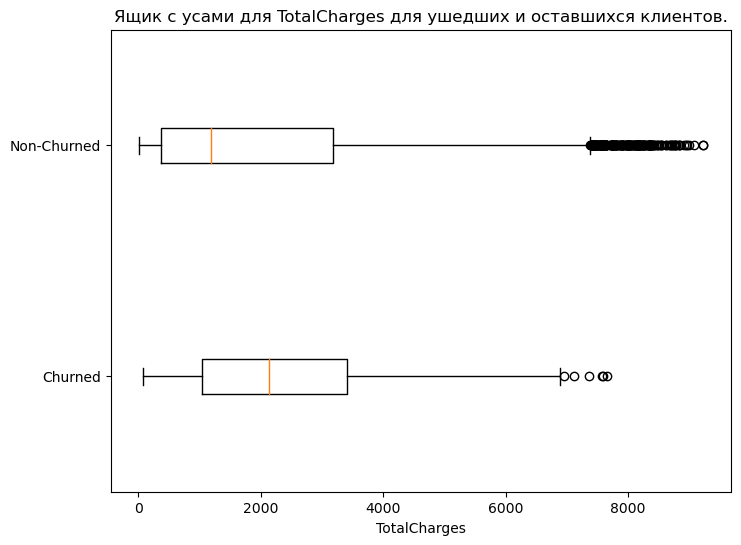

In [52]:
plt.figure(figsize=(8, 6))
plt.boxplot([df[df['Churn'] == 1]['TotalCharges'], df[df['Churn'] == 0]['TotalCharges']], vert=False)
plt.title('Ящик с усами для TotalCharges для ушедших и оставшихся клиентов.')
plt.xlabel('TotalCharges')
plt.yticks([1, 2], ['Ушедшие', 'Не ушедшие'])
plt.show()

Как видим по графику столбец TotalCharges в не ушедших  скошен в право, медианное значение  1343. график имеет много выбросов выше 4 квартиля около 8000
по ушедшим медиана около 2000, выбросы в районе 7000.

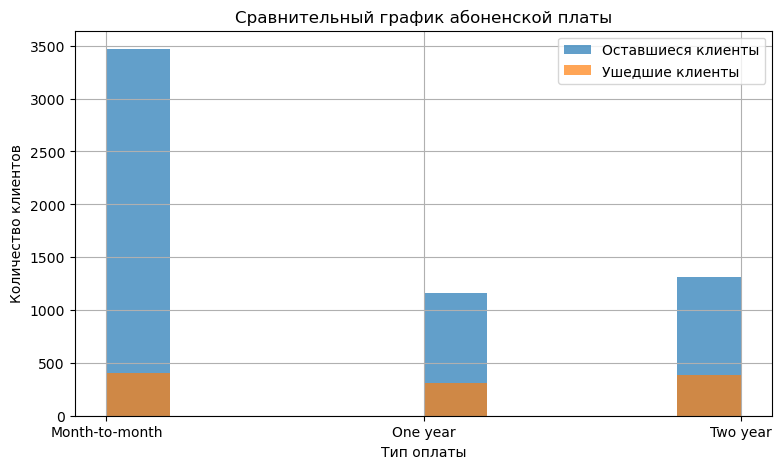

In [53]:
df.query('Churn == 0')['Type'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['Type'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график абоненской платы')
plt.xlabel('Тип оплаты')
plt.ylabel('Количество клиентов')
plt.show()

как видим по графику наиболее большее кол-во пользывателей использывала ежемесячный тип оплаты. Уход клиентов везде одинаковый, но если смотреть от суммарно, то большая додя уходят после годового/двухгодового контракта. Здесь и нужно удержать этих пользывателей. Так же нужно поступасть после месячной подписки

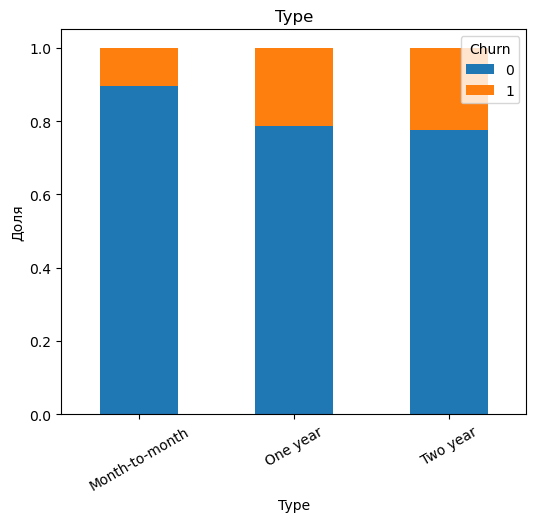

In [54]:
# код тимлида для объяснения
fig = plt.figure(figsize=(6, 5))
tmp = df.pivot_table(index='Churn', columns='Type', values='customerID', aggfunc='count')
tmp = tmp.div(tmp.sum(axis=0), axis=1).T
tmp.plot.bar(stacked=True, rot=30, ax=fig.gca())
plt.title('Type')
plt.xlabel('Type')
plt.ylabel('Доля')
plt.show()

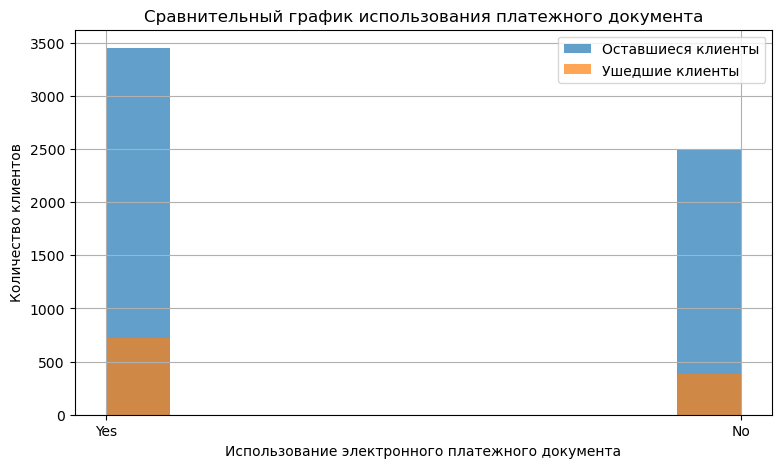

In [55]:
df.query('Churn == 0')['PaperlessBilling'].hist(alpha=0.7, legend=True,  figsize=(9, 5))
df.query('Churn == 1')['PaperlessBilling'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график использования платежного документа')
plt.xlabel('Использование электронного платежного документа')
plt.ylabel('Количество клиентов')
plt.show;

как видим оттока клиентов больше среди тех кто использует услуги PaperlessBilling

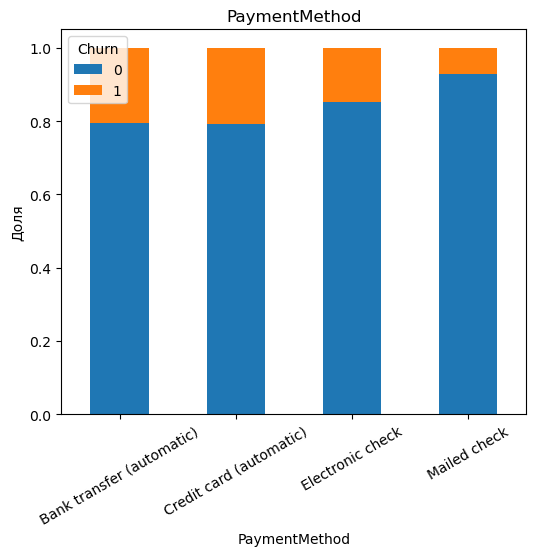

In [56]:
# код тимлида для проверки
fig = plt.figure(figsize=(6, 5))
tmp = df.pivot_table(index='Churn', columns='PaymentMethod', values='customerID', aggfunc='count')
tmp = tmp.div(tmp.sum(axis=0), axis=1).T
tmp.plot.bar(stacked=True, rot=30, ax=fig.gca())
plt.title('PaymentMethod')
plt.xlabel('PaymentMethod')
plt.ylabel('Доля')
plt.show()

как видим больше всего оттока клиентов среди тех кто пользуется автомотической оплатой с банка или с карты

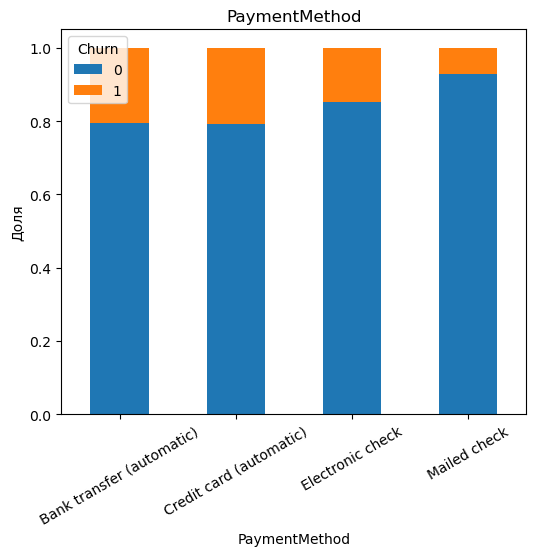

In [57]:
# код тимлида для проверки
fig = plt.figure(figsize=(6, 5))
tmp = df.pivot_table(index='Churn', columns='PaymentMethod', values='customerID', aggfunc='count')
tmp = tmp.div(tmp.sum(axis=0), axis=1).T
tmp.plot.bar(stacked=True, rot=30, ax=fig.gca())
plt.title('PaymentMethod')
plt.xlabel('PaymentMethod')
plt.ylabel('Доля')
plt.show()

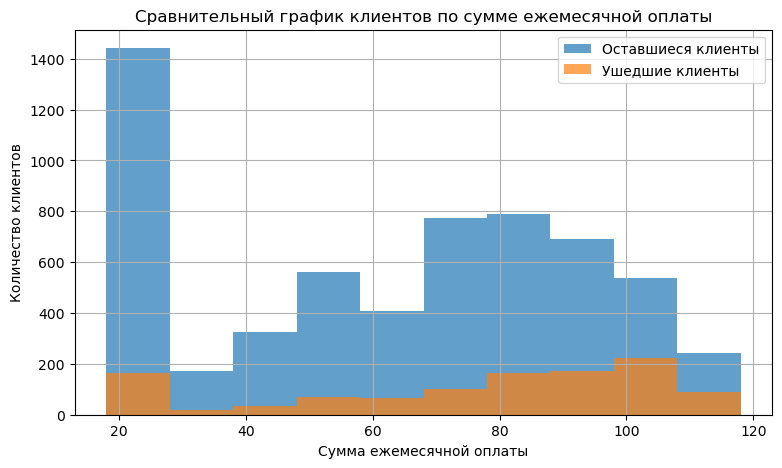

In [58]:
df.query('Churn == 0')['MonthlyCharges'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['MonthlyCharges'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по сумме ежемесячной оплаты')
plt.xlabel('Сумма ежемесячной оплаты')
plt.ylabel('Количество клиентов')
plt.show;

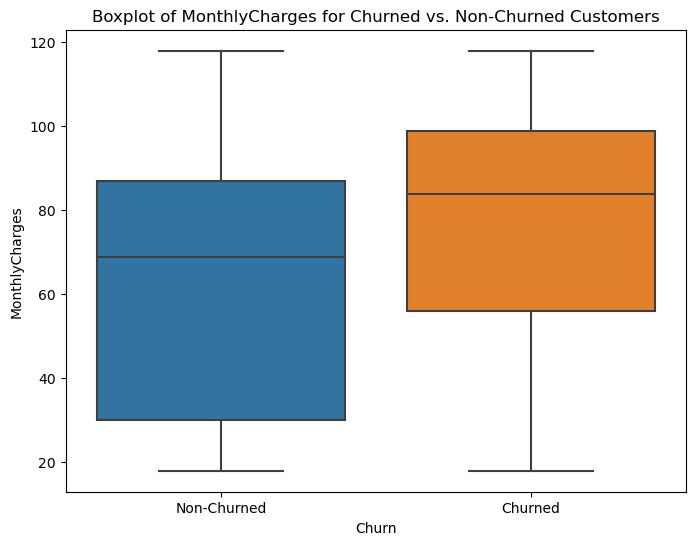

In [59]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Boxplot of MonthlyCharges for Churned vs. Non-Churned Customers')
plt.xlabel('Churn')
plt.ylabel('MonthlyCharges')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])  # Adding labels for the x-axis ticks
plt.show()

как видим по графикам есть разные распределения между оставшиемися  и ушедшими клиентами. Медиана ну и сам ящик выше  у ушедших клиентов, что говорит нам о том, что ушедшие клиенты обычно имеют более высокие ежемесячные платежи (медиана и верхний квартиль выше), чем клиенты, которые остаются

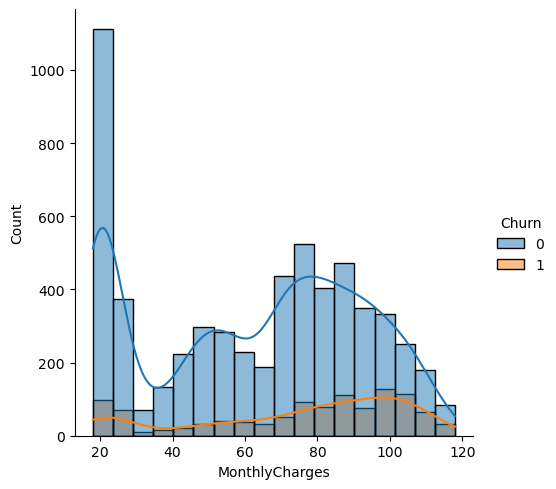

In [60]:
# код тимлида для объяснения
sns.displot(data=df, x='MonthlyCharges', hue='Churn', kind='hist', kde=True);

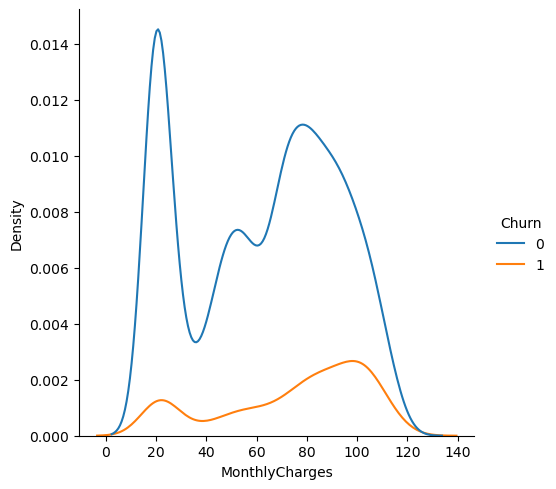

In [61]:
# код тимлида для объяснения
sns.displot(data=df, x='MonthlyCharges', hue='Churn', kind='kde');

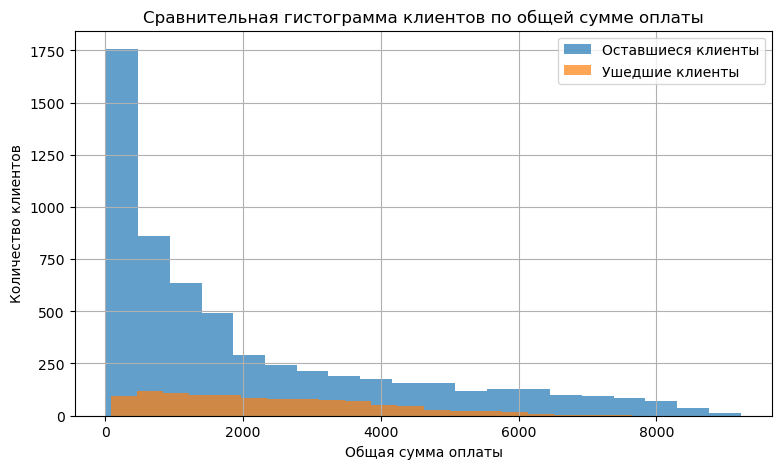

In [62]:
df.query('Churn == 0')['TotalCharges'].hist(alpha=0.7, legend=True, bins=20, figsize=(9, 5))
df.query('Churn == 1')['TotalCharges'].hist(alpha=0.7, legend=True, bins=20, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительная гистограмма клиентов по общей сумме оплаты')
plt.xlabel('Общая сумма оплаты')
plt.ylabel('Количество клиентов')
plt.show;


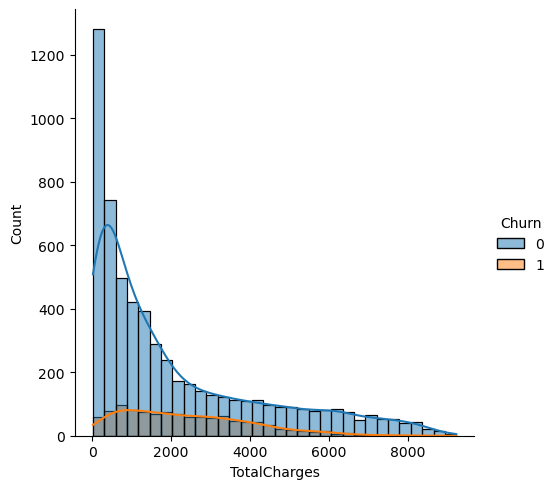

In [63]:
sns.displot(data=df, x='TotalCharges', hue='Churn', kind='hist', kde=True);

Как видим по графику кол-ва оставшихся клиентов резко уменьшается с увиличением общей суммы, в то время как кол-во ушедших клиентов +- держится на уровноне до отметки 5000

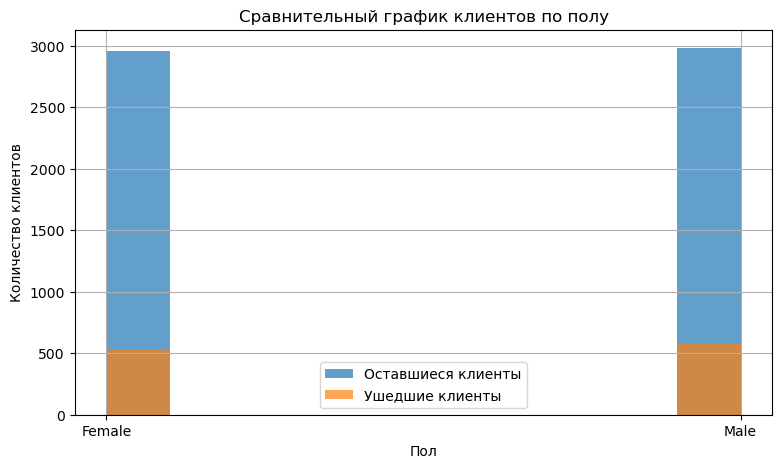

In [64]:
df.query('Churn == 0')['gender'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['gender'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по полу')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.show;

кол-во клиентов среди мужчин и женщин так же одинаково, как и среди ушедших абонентов

In [65]:
personal

customerID  gender SeniorCitizen Partner Dependents
0     7590-VHVEG  Female            No     Yes         No
1     5575-GNVDE    Male            No      No         No
2     3668-QPYBK    Male            No      No         No
3     7795-CFOCW    Male            No      No         No
4     9237-HQITU  Female            No      No         No
...          ...     ...           ...     ...        ...
7038  6840-RESVB    Male            No     Yes        Yes
7039  2234-XADUH  Female            No     Yes        Yes
7040  4801-JZAZL  Female            No     Yes        Yes
7041  8361-LTMKD    Male           Yes     Yes         No
7042  3186-AJIEK    Male            No      No         No

[7043 rows x 5 columns]

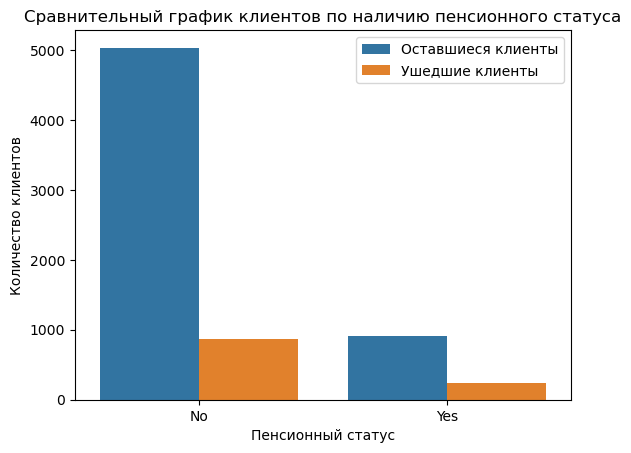

In [66]:
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Сравнительный график клиентов по наличию пенсионного статуса')
plt.xlabel('Пенсионный статус')
plt.ylabel('Количество клиентов')
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.show()

как видим по графику не пенсионеров больше среди ушедших клиентов

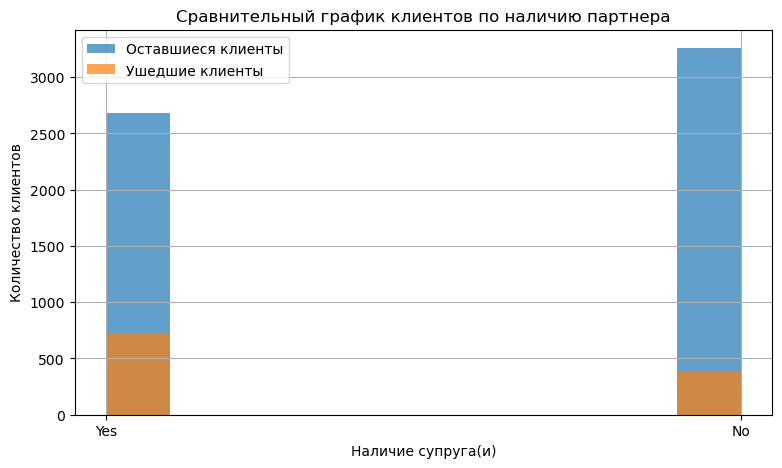

In [67]:
df.query('Churn == 0')['Partner'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['Partner'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по наличию партнера')
plt.xlabel('Наличие супруга(и)')
plt.ylabel('Количество клиентов')
plt.show;

доля ушедших заметно больше у людей с партнерами

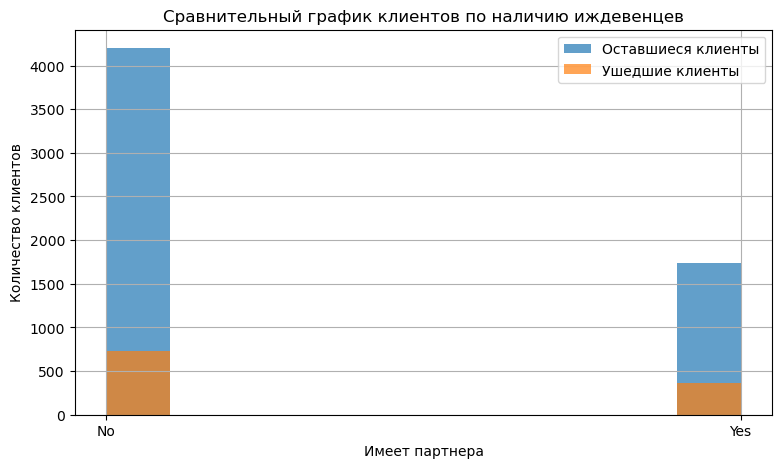

In [68]:
df.query('Churn == 0')['Dependents'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['Dependents'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по наличию иждевенцев')
plt.xlabel('Имеет партнера')
plt.ylabel('Количество клиентов')
plt.show;

среди клиентов не имеющих иждевенцов доля ушедших чуть больше

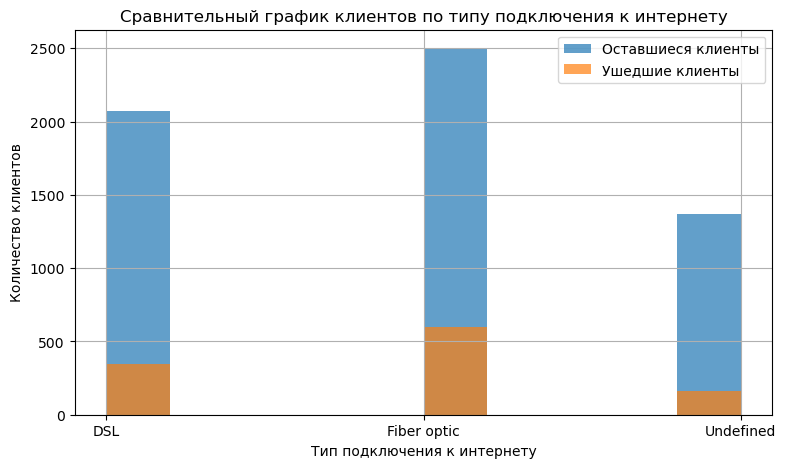

In [69]:
df.query('Churn == 0')['InternetService'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['InternetService'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по типу подключения к интернету')
plt.xlabel('Тип подключения к интернету')
plt.ylabel('Количество клиентов')
plt.show;

немного боольше среди ушедших пользыватели оптоволокна, но это услугой пользывались больше всего

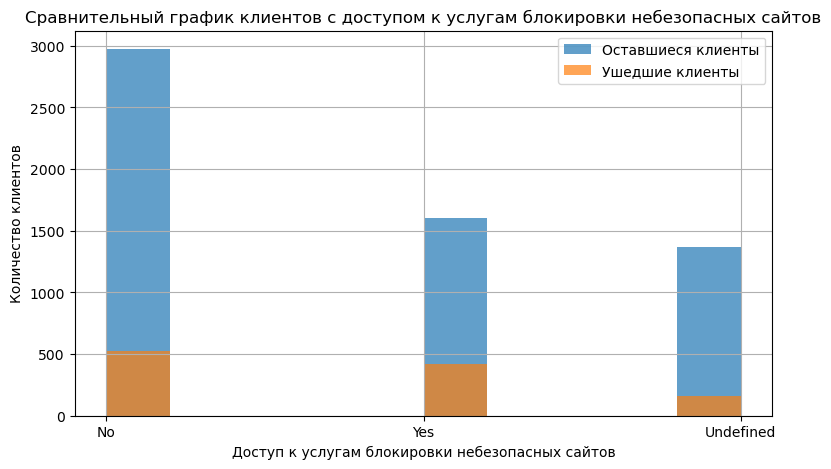

In [70]:
df.query('Churn == 0')['OnlineSecurity'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['OnlineSecurity'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с доступом к услугам блокировки небезопасных сайтов')
plt.xlabel('Доступ к услугам блокировки небезопасных сайтов')
plt.ylabel('Количество клиентов')
plt.show;

как видим доли распределены почти одинаково

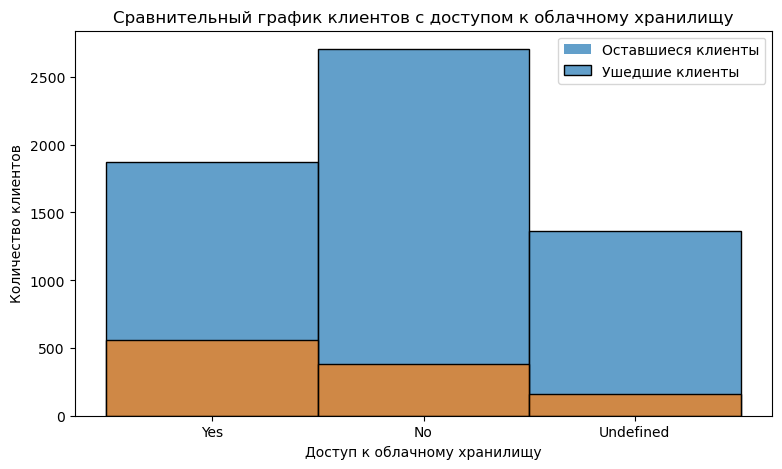

In [71]:

plt.figure(figsize=(9, 5))

# Create histograms with colored bars
sns.histplot(data=df.query('Churn == 0'), x='OnlineBackup', alpha=0.7, legend=True, bins=2)
sns.histplot(data=df.query('Churn == 1'), x='OnlineBackup', alpha=0.7, legend=True, bins=2)

# Set labels and title
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с доступом к облачному хранилищу')
plt.xlabel('Доступ к облачному хранилищу')
plt.ylabel('Количество клиентов')

plt.show()


Как видим доля ушедших клиентов которые использывали услугу OnlineBackup больше 

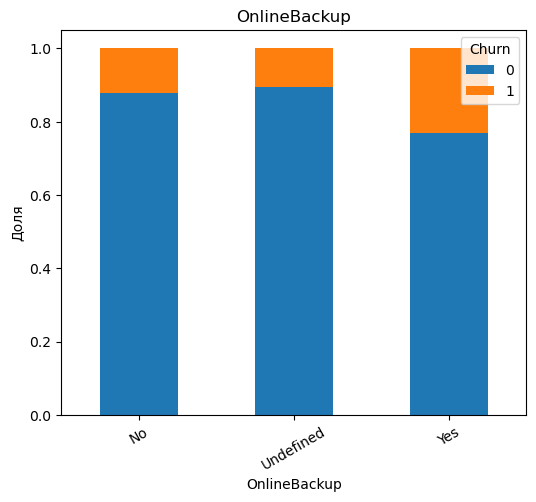

In [72]:
# код тимлида для проверки
fig = plt.figure(figsize=(6, 5))
tmp = df.pivot_table(index='Churn', columns='OnlineBackup', values='customerID', aggfunc='count')
tmp = tmp.div(tmp.sum(axis=0), axis=1).T
tmp.plot.bar(stacked=True, rot=30, ax=fig.gca())
plt.title('OnlineBackup')
plt.xlabel('OnlineBackup')
plt.ylabel('Доля')
plt.show()

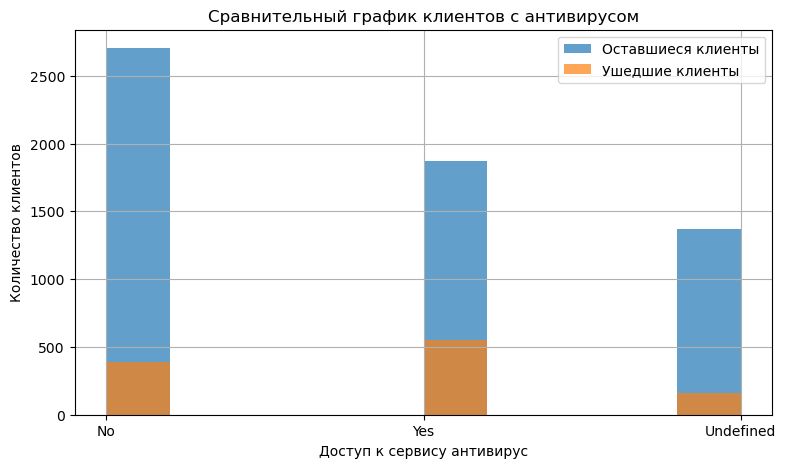

In [73]:
df.query('Churn == 0')['DeviceProtection'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['DeviceProtection'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с антивирусом')
plt.xlabel('Доступ к сервису антивирус')
plt.ylabel('Количество клиентов')
plt.show; 

доля тех кто использывал услугу DeviceProtection больше

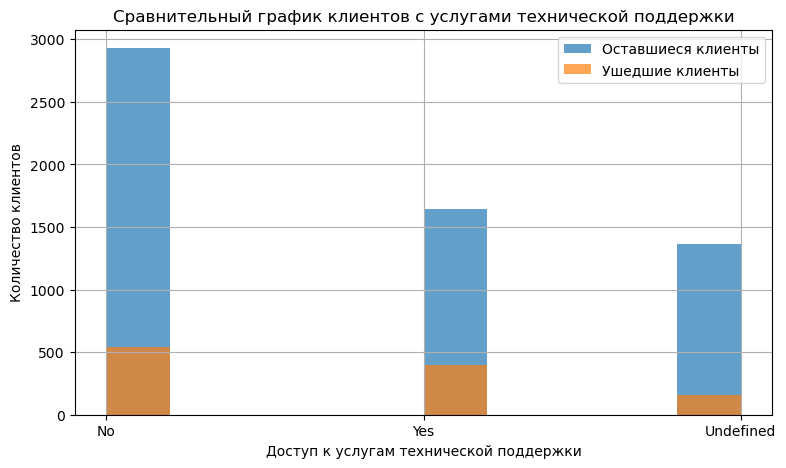

In [74]:
df.query('Churn == 0')['TechSupport'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['TechSupport'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с услугами технической поддержки')
plt.xlabel('Доступ к услугам технической поддержки')
plt.ylabel('Количество клиентов')
plt.show;

доля тех кто не использывал услугу DeviceProtection больше

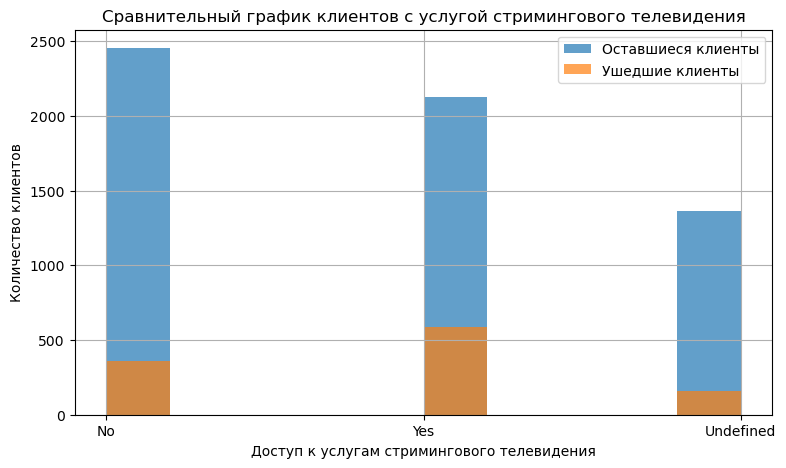

In [75]:
df.query('Churn == 0')['StreamingTV'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['StreamingTV'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с услугой стримингового телевидения')
plt.xlabel('Доступ к услугам стримингового телевидения')
plt.ylabel('Количество клиентов')
plt.show;

доля тех кто использывал услугу StreamingTV больше

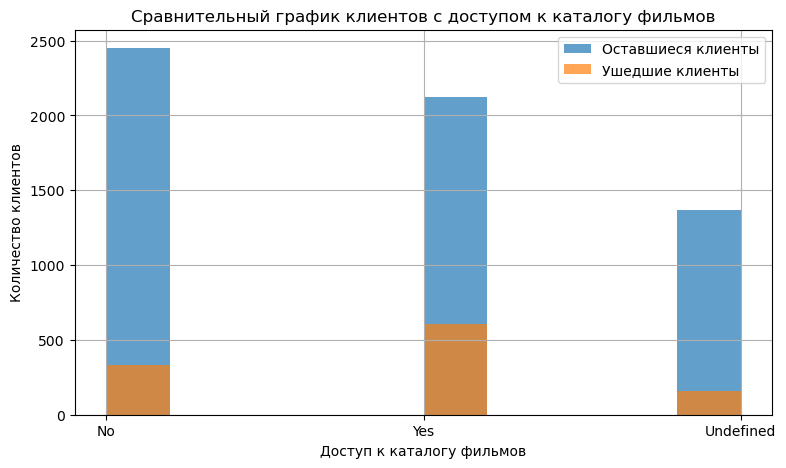

In [76]:
df.query('Churn == 0')['StreamingMovies'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['StreamingMovies'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с доступом к каталогу фильмов')
plt.xlabel('Доступ к каталогу фильмов')
plt.ylabel('Количество клиентов')
plt.show;

доля тех кто использывал услугу StreamingMovies больше

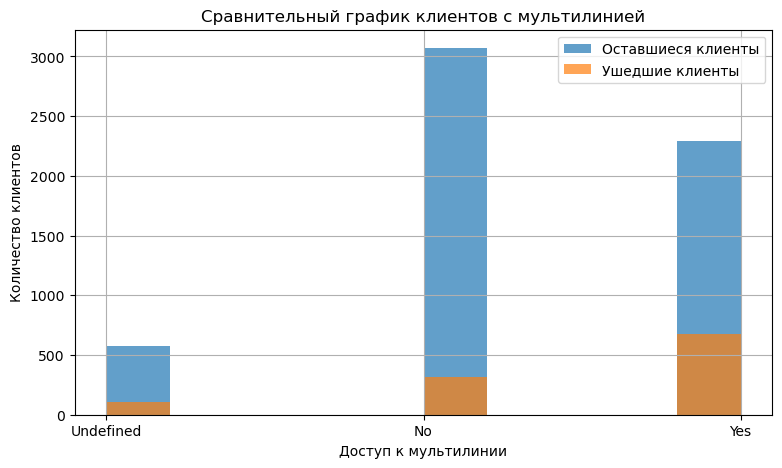

In [77]:
df.query('Churn == 0')['MultipleLines'].hist(alpha=0.7, legend=True, figsize=(9, 5))
df.query('Churn == 1')['MultipleLines'].hist(alpha=0.7, legend=True, figsize=(9, 5))
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов с мультилинией')
plt.xlabel('Доступ к мультилинии')
plt.ylabel('Количество клиентов')
plt.show;

доля тех кто использывал услугу MultipleLines больше

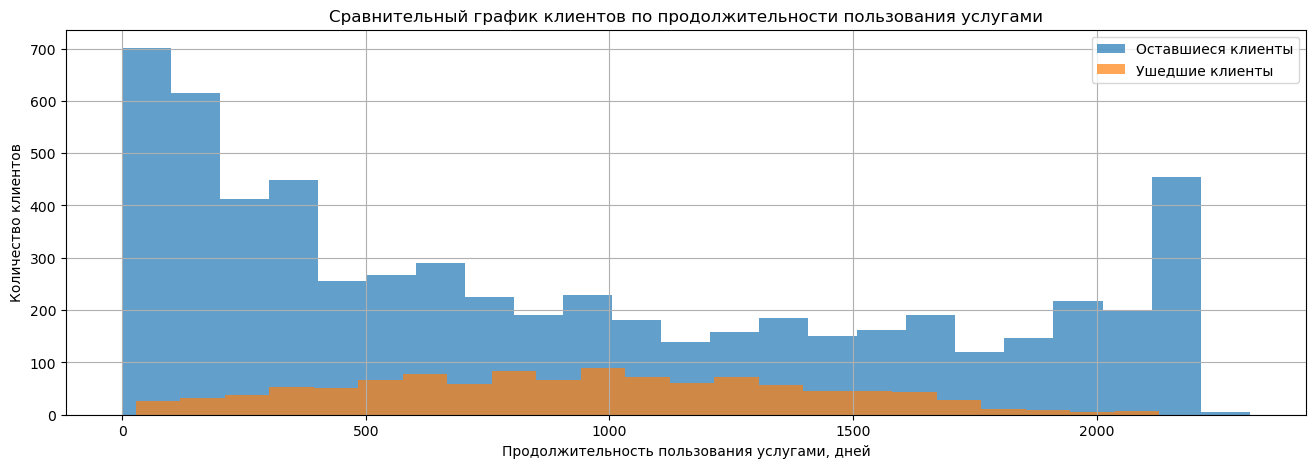

In [78]:
df.query('Churn == 0')['duration'].hist(alpha=0.7, legend=True, figsize=(16, 5), bins=23)
df.query('Churn == 1')['duration'].hist(alpha=0.7, legend=True, figsize=(16, 5), bins=23)
plt.legend(['Оставшиеся клиенты', 'Ушедшие клиенты'])
plt.title('Сравнительный график клиентов по продолжительности пользования услугами')
plt.xlabel('Продолжительность пользования услугами, дней')
plt.ylabel('Количество клиентов')
plt.show;

наблюдается пик ушедших клинтов в районе 600-700-900-1200 дней, стоить задействовать купоны на эти сроки

#### Проверка корреляций



In [79]:
from phik import report
from phik.report import plot_correlation_matrix

In [80]:
df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'duration'],
      dtype='object')

In [81]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [82]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'duration']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

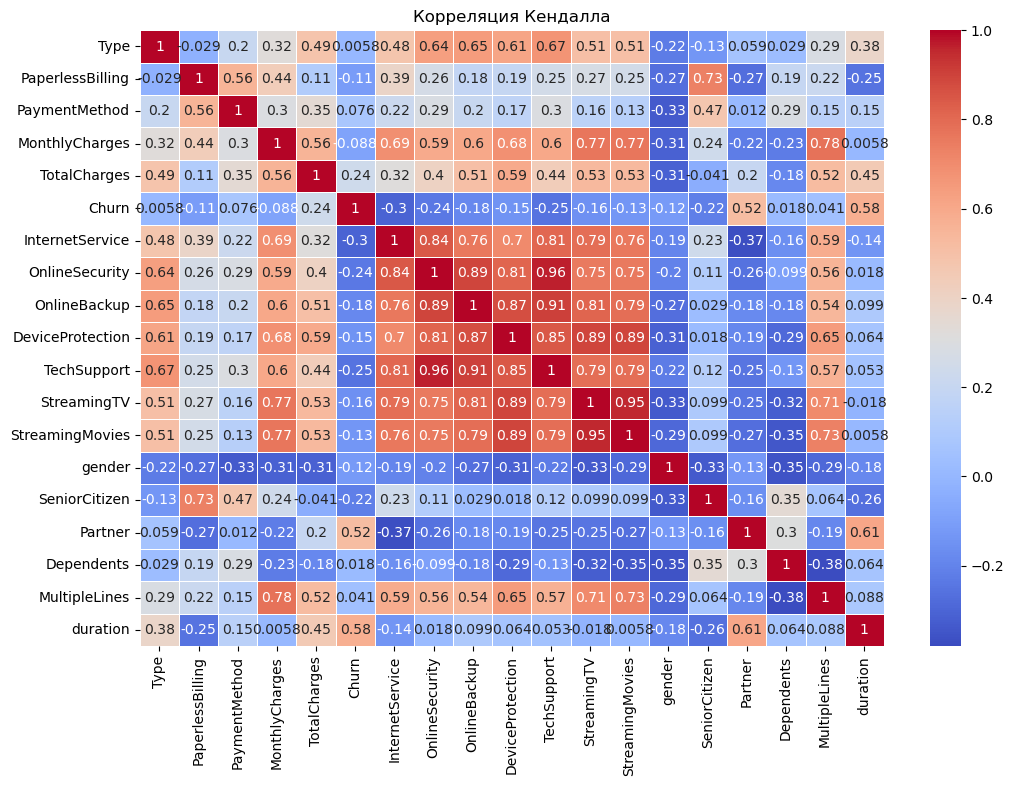

In [83]:
correlation_matrix = phik_overview.corr(method='kendall')

# Построение тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляция Кендалла')
plt.show()

как видим по графику, высокий кф корреляций между переменными:
- столбцами InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'StreamingTV'.
- Особенно TechSupport и OnlineSecurity, StreamingMovies и StreamingTv


Удалим признак Gender, из за низкой корреляции, так же StreamingMovies и TechSupport из за высокой

In [84]:
df = df.drop(['gender', 'StreamingMovies', 'TechSupport', 'InternetService', 'StreamingTV'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   int32  
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int32  
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   SeniorCitizen     7043 non-null   object 
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  duration          7043 non-null   int64  
dtypes: float64(1), int32(2), int64(1), object(10)
memory usage: 1.0+ MB


#### Промежуточный Вывод

Данные были получены и прошли предварительную обработку. В процессе обработки не было обнаружено дубликатов или пропущенных значений. Мы привели столбцы к нужным форматам данных и создали целевой признак. Также был добавлен столбец "duration" для более детального анализа. мы объединили все данные в один датасет.

Для подготовки данных к обучению модели, мы решили удалить неинформативные столбцы. Отметим, что признак "gender" не оказывает влияния на другие признаки, поэтому мы решили исключить его из обучения. Также столбцы "EndDate", "BeginDate" и "CustomerId" были удалены, поскольку они не несут существенной информации для модели.

## 3. Подготовка выборки для обучения моделей.

In [85]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from catboost import CatBoostClassifier

In [86]:
RANDOM_STATE = 2102023

In [87]:
features = df.drop('Churn', axis=1)
target = df.Churn

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [88]:
print(features_train.shape , features_test.shape)
print(target_train.shape , target_test.shape)

(5282, 13) (1761, 13)
(5282,) (1761,)


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   int32  
 4   TotalCharges      7043 non-null   float64
 5   Churn             7043 non-null   int32  
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   SeniorCitizen     7043 non-null   object 
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  duration          7043 non-null   int64  
dtypes: float64(1), int32(2), int64(1), object(10)
memory usage: 1.0+ MB


In [90]:
df.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'duration'],
      dtype='object')

### CatBoostClassifier

In [96]:
num_cols = ['duration', 'TotalCharges', 'MonthlyCharges']
cat_cols = ['PaperlessBilling', 'PaymentMethod', 'SeniorCitizen',
            'Partner', 'Dependents', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection',
            'MultipleLines', 'Type']

In [97]:
scorers = {'accuracy':'accuracy', 'roc_auc':'roc_auc'}

In [98]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

In [99]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols)
    ])


# Создаем конвейер с преобразованиями и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, early_stopping_rounds=200))
])

# Определяем сетку гиперпараметров для поиска
param_grid = {
    'model__learning_rate': [0.1],
    'model__depth': [2, 5, 10],
    'model__iterations': [1000, 2000]
}

# Кросс-валидация с 3 фолдами 
grid_search_cat = GridSearchCV(pipeline,
                               param_grid,
                               scoring=scorers,
                               refit='roc_auc',
                               cv=3)

In [100]:
%time
grid_search_cat.fit(features_train, target_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['duration',
                                                                          'TotalCharges',
                                                                          'MonthlyCharges']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'MultipleLines',
                                                                          'Type'])])),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001C9AAF11A90>)]),
             param_grid={'model__depth': [2, 5, 10],
                         'model__iterations': [1000, 2000],
                         'model__learning_rate': [0.01, 0.1]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'})

In [101]:
grid_search_cat.best_params_

{'model__depth': 2, 'model__iterations': 2000, 'model__learning_rate': 0.1}

In [102]:
grid_search_cat.best_score_

0.9187133146267441

In [103]:
result_cat = grid_search_cat.best_score_
result_cat

0.9187133146267441

#### LightGBM

In [104]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline

In [105]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder, cat_cols)

    ])
# Создаем конвейер с преобразованиями и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

# задаем сетки гиперпараметров
grid_params_lgbm = {
    'model__boosting_type': ['gbdt'],
    'model__objective': ['binary'],
    'model__num_leaves': [11, 21, 31],
    'model__max_depth': [2, 5, 10],
    'model__num_iterations': [1000, 2000],
    'model__learning_rate': [0.01, 0.1],
    'model__num_threads': [1]
}

# Кросс-валидация с 3 фолдами 
grid_search_lgbm = GridSearchCV(pipeline,
                               grid_params_lgbm,
                               scoring=scorers,
                               refit='roc_auc',
                               cv=3)

In [106]:
%time
grid_search_lgbm.fit(features_train, target_train)

CPU times: total: 0 ns
Wall time: 0 ns
[LightGBM] [Info] Number of positive: 551, number of negative: 2970
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 533
[LightGBM] [Info] Number of data points in the train set: 3521, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156490 -> initscore=-1.684582
[LightGBM] [Info] Start training from score -1.684582
[LightGBM] [Info] Number of positive: 550, number of negative: 2971
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 532
[LightGBM] [Info] Number of data points in the train set: 3521, number of u

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['duration',
                                                                          'TotalCharges',
                                                                          'MonthlyCharges']),
                                                                        ('cat',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'Devic...
                                                                          'Type'])])),
                                       ('model',
                                        LGBMClassifier(random_state=2102023))]),
             param_grid={'model__boosting_type': ['gbdt'],
                         'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [2, 5, 10],
                         'model__num_iterations': [1000, 2000],
                         'model__num_leaves': [11, 21, 31],
                         'model__num_threads': [1],
                         'model__objective': ['binary']},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'})

In [107]:
grid_search_lgbm.best_score_

0.8950821502721088

In [108]:
grid_search_lgbm.best_params_

{'model__boosting_type': 'gbdt',
 'model__learning_rate': 0.1,
 'model__max_depth': 2,
 'model__num_iterations': 2000,
 'model__num_leaves': 11,
 'model__num_threads': 1,
 'model__objective': 'binary'}

In [109]:
best_params_lgb = grid_search_lgbm.best_params_
result_lgbm = grid_search_lgbm.best_score_

### LogisticRegression

In [110]:
from sklearn.linear_model import LogisticRegression

encoder_ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encoder_ohe, cat_cols)
        ])
# Create the Logistic Regression classifier
logistic_reg = LogisticRegression(random_state=RANDOM_STATE)

# Define the grid of hyperparameters to search
grid_params_logistic = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 100, 200, 500, 1000],
    'class_weight': ['balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [200],
    'multi_class': ['auto', 'ovr', 'multinomial']
}

# Create a new pipeline with preprocessing and the logistic regression model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GridSearchCV(
        estimator=logistic_reg,
        param_grid=grid_params_logistic,
        scoring=scorers,
        refit='roc_auc',
        return_train_score=True,
        cv=3,
        verbose=2
    ))
])


In [111]:
logistic_pipeline.fit(features_train, target_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, class_weight=balanced, max_iter=200, multi_class=auto, penalty=l1, solver=newton-cg; total ti

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'TotalCharges',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'MultipleLines',
                                                   'T...
                              estimator=LogisticRegression(random_state=2102023),
                              param_grid={'C': [0.1, 1, 10, 100, 200, 500,
                                                1000],
                                          'class_weight': ['balanced'],
                                          'max_iter': [200],
                                          'multi_class': ['auto', 'ovr',
                                                          'multinomial'],
                                          'penalty': ['l1', 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']},
                              refit='roc_auc', return_train_score=True,
                              scoring={'accuracy': 'accuracy',
                                       'roc_auc': 'roc_auc'},
                              verbose=2))])

In [112]:
best_params_logistic = logistic_pipeline.named_steps['model'].best_params_
result_logistic = logistic_pipeline.named_steps['model'].best_score_

print("Best hyperparameters for Logistic Regression:", best_params_logistic)
print("Best AUC-ROC score for Logistic Regression:", result_logistic)


Best hyperparameters for Logistic Regression: {'C': 500, 'class_weight': 'balanced', 'max_iter': 200, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}
Best AUC-ROC score for Logistic Regression: 0.7560532218550803


In [113]:
results = [
    {'Model': 'Logistic Regression', 'AUC-ROC': result_logistic},
    {'Model': 'CatBoost', 'AUC-ROC': result_cat},
    {'Model': 'LightGBM', 'AUC-ROC': result_lgbm}
]

leaderboard = pd.DataFrame(results)

leaderboard = leaderboard.sort_values(by='AUC-ROC', ascending=False)

leaderboard.reset_index(drop=True, inplace=True)

display(leaderboard)

Model   AUC-ROC
0             CatBoost  0.918713
1             LightGBM  0.895082
2  Logistic Regression  0.756053

### Промежуточный вывод

Все три модели были протестированы с использованием пайплайнов и кросс-валидации. При использовании пайплайнов мы предотвращаем утечку данных и упрощаем код, так как нет необходимости повторно кодировать признаки. Наилучшие результаты на обучающей выборке продемонстрировала модель CatBoost. Теперь мы проверим ее на тестовой выборке, чтобы убедиться в ее производительности на новых данных.

In [114]:
print(f'Тестовый результат метрики AUC-ROC: {round(grid_search_cat.score(features_test, target_test), 2)}')

Тестовый результат метрики AUC-ROC: 0.93


#### Accuracy score

In [115]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc

In [116]:
best_cat_model = grid_search_cat.best_estimator_
predicted_labels = best_cat_model.predict(features_test)

accuracy = accuracy_score(target_test, predicted_labels)
accuracy

0.9449176604202157

такая доля правильных ответов говорит нам о том, что модель правильно классифицировала 94% тестовых данных.

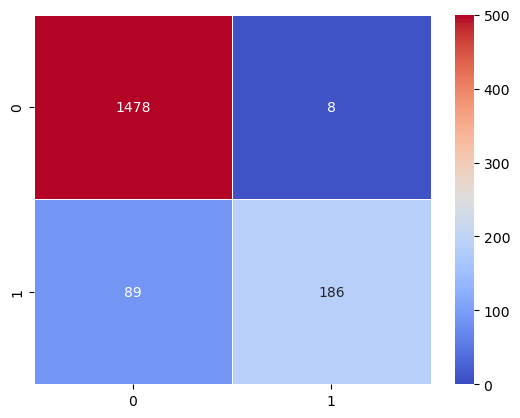

In [117]:
cnf_matrix = confusion_matrix(target_test, best_cat_model.predict(features_test))
sns.heatmap(cnf_matrix, annot=True, fmt=".0f", linewidth=.5, cmap= 'coolwarm', vmin = 0, vmax = 500)
plt.show()

Как видим модель довольно хорошо предсказывает, из 1 761 ошибочными яв-ся 97 наблюдений (FP/FN) из тестовых данных.

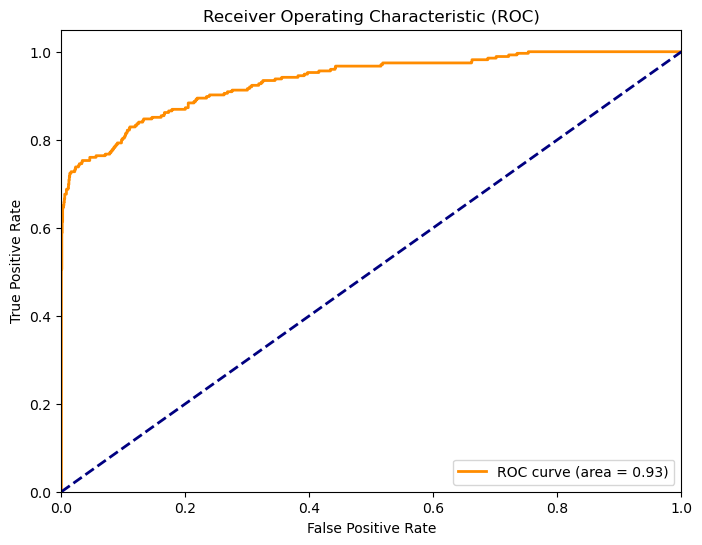

In [118]:
y_pred_prob = grid_search_cat.predict_proba(features_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(target_test, y_pred_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


AUC равная 0.94 говорит о том, что модель имеет высокую способность разделять классы и делать точные прогнозы

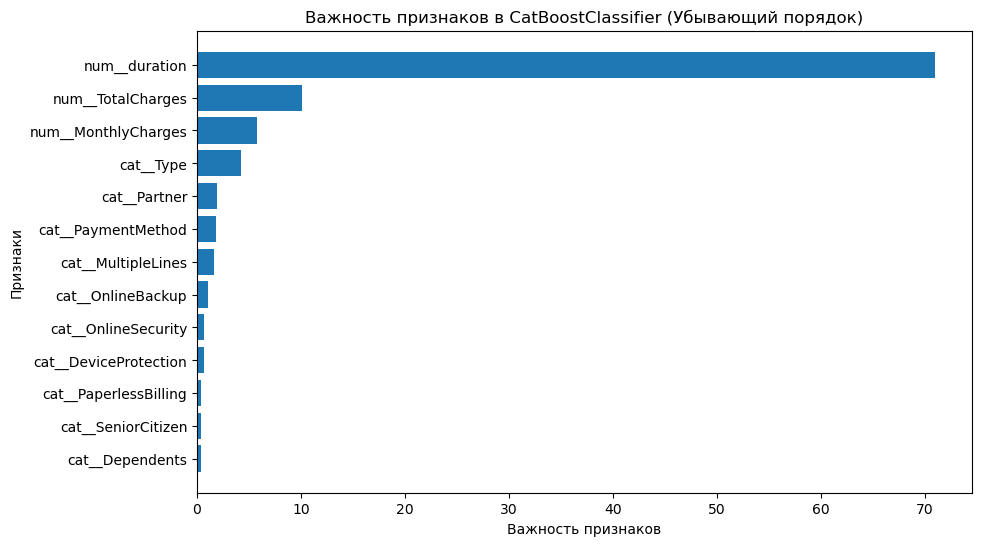

In [119]:
# модель CatBoost из пайплайна
catboost_model = best_cat_model.named_steps['model']

# преобразователь признаков из конвейера
preprocessor = best_cat_model.named_steps['preprocessor']

# важности признаков
feature_importances = catboost_model.feature_importances_

# имена преобразованных признаков в правильном порядке
transformed_feature_names = best_cat_model[:-1].get_feature_names_out()

# словарь, сопоставляя важности и имена признаков
feature_importance_dict = dict(zip(transformed_feature_names, feature_importances))

# словарь по важности в порядке убывания
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=False)

# имена признаков и их важности
sorted_feature_names = [x[0] for x in sorted_feature_importance]
sorted_importances = [x[1] for x in sorted_feature_importance]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков в CatBoostClassifier (Убывающий порядок)')
plt.show()


'InternetService', 'StreamingTV' удалены, так как никак не влияют на модель

### Вывод

лучше себя показала модель Catboost на тестовой выборке Auc-roc 0.94, accuracy 0.93. Модель довольно хорошо себя ведет, ошибочно показываю только 100 наблюдений из 1716. По важности признаков сильно в отрыве Duration, она и не удивительно, как мы ранее исследовали основной поток ушедших это те у кого заканчивались годовые, 2-х и.тд контракты.  Так же имеются признаки которые вообще не оказывают влияниее на решение клиента уйти или остаться.

# Отчет о проделанной работе

**В ходе работы были выполнены следющие операции:**
  #### 1. Загружены и изучены данные;
  
  #### 2. Выполнена предобработка данных;

Пропусков в исходном датасете не наблюдалось, но после объеденения датасетов появились пропуски. Они появились из за того что, не все пользыватели пользывались всеми услугами компании.(Например телефонии и интернетом.) такие пропуски были заменены на 'Undefined'


 #### 3. Сформированы признаки;

Duration, целевой признак  Churn

  #### 4. Проведён исследовательский анализ данных;
  
 
  #### 5. Проведена проверка данных на коллинеарность;
  
Удалены признаки непригодные для ML: EndDate, StardDate, CustomerId
  
удалены за низкую и высокую корреляцию Gender, StreamingMovies и TechSupport.


  #### 6. Подготовлены тренировочная и тестовая выборки;
  
RANDOM_STATE = 2102023, данные разделены 3 к 1
 
  #### 7. Выбрано несколько моделей, определены их лучшие гиперпаметры, модели обучены, протестировано предсказание лучшей модели;
  
  
  #### 8. Анализ важности признаов. 
  
  У выбранной модели было установлено, что призанки 'InternetService', 'StreamingTV' никак не влияют на принятие решение модели, и они были удалены. По важности cильно в отрыве Duration, она и не удивительно, как мы ранее исследовали основной поток ушедших это те у кого заканчивались годовые, 2-х и.тд контракты.
  
**Ключевые шаги в решении задачи**
  1. Анализ данных и подготовка признаков;
  2. Настройка моделей.
  
**Признаки для обучения модели и их предобработка**
  1. Для обучения модели использовались исходные признаки за исключением 'gender', 'begin_date', 'end_date', 'StreamingMovies', 'TechSupport' и один дополнительно сгенерированный признак 'duration' - срок действия контракта в днях;
  2. Данные всех признаков приведены к требуемому типу, отсутсвующие значения заполнены, дубликаты отсутвуют.
  
**Итоговая модель, её гиперпараметы и качество**
  1. Итоговая модель CatBoostClassifier со следующими параметрами:
- depth = 2
- iterations = 2000
- learning_rate = 0.1
  2. Тестовый результат метрики AUC-ROC: 0.93 
  3. Тестовый результат метрики Accuracy: 0.94
    

Данная модель CatBoostClassifier была тщательно настроена и протестирована на тестовой выборке, продемонстрировав выдающееся качество предсказаний. Это позволяет с большой уверенностью рекомендовать её использование для решения задачи бизнес-заказчика, связанной с прогнозированием оттока клиентов.

Гиперпараметры модели: Глубина дерева (depth), количество итераций (iterations) и скорость обучения (learning_rate) были оптимально настроены и подобраны на тренировочных данных. Эти гиперпараметры позволили достичь высокой производительности модели.

Метрики качества:

AUC-ROC (Area Under the Receiver Operating Characteristic Curve) составляет 0.93. Это означает, что модель хорошо различает классы и обладает способностью выявлять клиентов, склонных к оттоку.
Accuracy составляет 0.94, что также является впечатляющим результатом и указывает на точность модели.
Внедрение в эксплуатацию:

Модель может быть использована для идентификации клиентов, которые вероятно покинут компанию, что позволит предпринимать целенаправленные действия по удержанию таких клиентов.
Эффективность модели также позволит компании оптимизировать бюджет и ресурсы, направленные на удержание клиентов. Модель поможет сосредоточить усилия на наиболее перспективных клиентах.
Периодическое обновление модели с учетом появляющихся данных и изменений в компании позволит поддерживать её актуальность и эффективность.
В целом, данная модель представляет собой мощный инструмент для борьбы с оттоком клиентов и повышения эффективности работы компании. Следует рассмотреть её внедрение в рамках бизнес-процессов с последующим мониторингом и обновлением для достижения наилучших результатов.